## Определение параметров вероятностных распределений по значениям квантилей и мат. ожиданию
Подход заключается в минимизации квадратов разности на заданных перцентилях.
Пусть у нас есть значения квантилей:
$$
\begin{align*}
q_{0.05}&=f(0.05,\theta)\\
q_{0.5}&=f(0.5,\theta)\\
q_{0.95}&=f(0.95,\theta)\\
\end{align*}
$$
И у нас есть мат. ожидание $E[\theta]$

Тогда минимизируя функцию:

$$
\begin{align*}
k_1\cdot(q_{0.05}-f(0.05,\theta))^2+k_2\cdot(q_{0.5}-f(0.5,\theta))^2 + k_3\cdot(q_{0.95}-f(0.95,\theta))^2 \rightarrow min
\end{align*}
$$
при
$$k1_1=k_2=k_3=const$$

Законы распределения параметризируем через мат. ожидание $E[\theta]$ и параметр формы, который как раз и будем подбирать.

In [14]:
# Загрузка нужных библиотек
import numpy as np
from scipy.stats import gamma, beta, lognorm, norm, loguniform
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import pandas as pd

# Отключение ворнингов
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

In [15]:
ci90 = 1.64485
# Функция выполняет подгон параметра распределения для заданного закона распределения
def distr_fit(distr_type ,quantiles, probabilities, expectation, k=1, bounds=np.array([1e-3, 1e+3])):
    # Задаём функцию ошибки
    func = {
        'gamma': lambda x:
        # для гамма распределения
        # a-shape (k)
        # scale-theta scale (mean=shape*scale)
        (k*(gamma.ppf(quantiles, a=x, scale=expectation/x)-probabilities)**2).sum(),

        'beta': lambda x:
        # для бета распределения
        # a-alpha shape
        # b-beta shape (mean=alpha/(alpha-beta)
        (k*(beta.ppf(quantiles, a=x, b=x/expectation-x)-probabilities)**2).sum(),
        
        'lognorm': lambda EF:
        # для лог-нормлаьного распределения
        # s-среднеквадратическое отклонение (EF=p95/p50) (sigma=log(EF)/CI90)
        # scale-медиана (scale=exp(mu))ci90 = 1.64485
        (k*(lognorm.ppf(quantiles, s=np.log(EF)/ci90, scale = expectation*np.exp(-((np.log(EF)/ci90)**2)/2))-probabilities)**2).sum(),
        
        'norm': lambda sigma:
        # для нормлаьного распределения
        # loc-мат. ожидание
        # scale-среднеквадратическое отклонение
        (k*(norm.ppf(quantiles, loc=expectation, scale=sigma)-probabilities)**2).sum()
        
        #'loguniform': lambda x:
        # для loguniform
        # a - a shape
        # b - b shape (mean = (b-a)/ln(b/a))
        #(k*(loguniform.ppf(quantiles, a=x, b=)-probabilities)**2).sum()
    }.get(distr_type, None)
    if func is None: return None
    # Минимизируем функцию ошибки по одному параметру
    res = minimize_scalar(func, bounds=bounds, method='bounded')
    # Возвращаем параметр
    return [res.x, res.fun]

В ПО RiskSpectrum даются ограничения на допустимые значения параметров распределения:
* Both for gamma and beta distributions the shape parameter $\alpha$ is limited to be $0.1 \leq \alpha \leq 20.0$.
* The error factor (EF) used for lognormal distributions must be $1 < EF < 10000$
* The standard deviation for the normal distribution is limited to be less than approximately 60.8% of the mean value. If the standard deviation is higher, a considerable tail of the distribution extends out on the negative domain, which cannot be allowed for any of the parameter types. Actually, distributions with 0% and 1% percentiles lower than 0 are accepted, but in that case these percentiles are truncated to 0.

In [16]:
# Получение доступа к гугл диску
#from google.colab import drive
#drive.mount('/content/drive')
# Загрузка данных
df = pd.read_excel('data.xlsx', sheet_name='data')
# Показать пару первых строк
df.head()

,name,p05,p50,p95,mean
0,"Centrifugal pump, horizontal (Spurious stop)",3.000000e-07,6.100000e-06,0.000027,9.100000e-06
1,"Centrifugal pump, horizontal (Failure to start)",2.000000e-08,1.820000e-06,0.000012,3.620000e-06
2,Fan (Spurious stop),0.000000e+00,0.000000e+00,0.000068,1.740000e-05
3,Fan (Failure to start),0.000000e+00,5.000000e-08,0.000004,8.500000e-07
4,"Isolation valves, motor operated, gate valve (...",1.000000e-07,2.100000e-06,0.000010,3.200000e-06


In [17]:
# Настройка стиля рисунков
# Включение модного, черного стиля для рисунков
#plt.style.use('dark_background')
# Изменение стандартного шрифта на Linux-своместимый
#plt.rcParams["font.family"] = 'Liberation Mono'
# Изменяем стандартный размер шрифта
plt.rcParams.update({'font.size': 12})
# Изменяем стандартный размер картинки
plt.rcParams['figure.figsize'] = [16, 8]

Centrifugal pump, horizontal (Spurious stop)
Gamma: param=0.98928, fun=6.068e-14 
 Beta: param=0.98927, fun=6.0679e-14
 Lognorm: param=46.727, fun=3.0571e-11
 Norm: param=2.1133e-06, fun=2.5414e-10


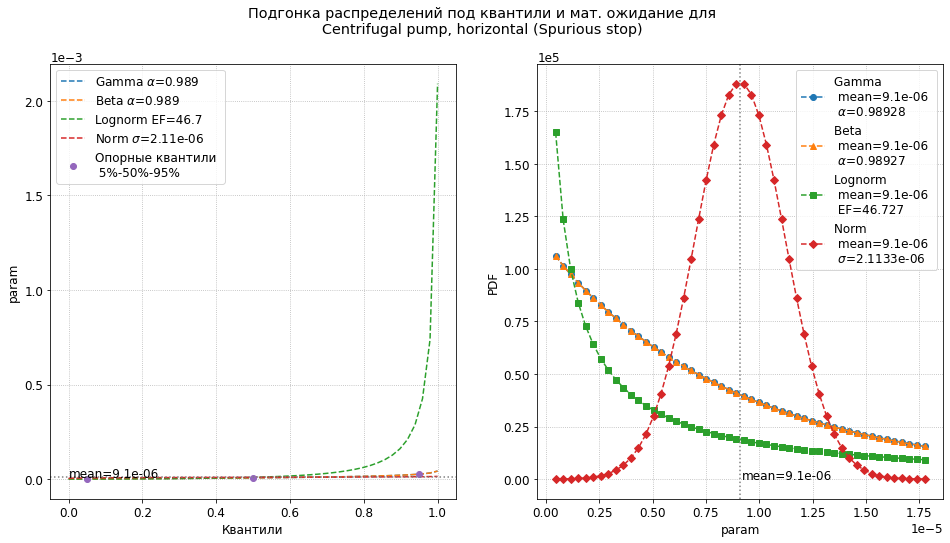

Centrifugal pump, horizontal (Failure to start)
Gamma: param=0.70705, fun=9.9357e-14 
 Beta: param=0.70705, fun=9.9358e-14
 Lognorm: param=33.894, fun=2.151e-12
 Norm: param=8.4069e-07, fun=5.9812e-11


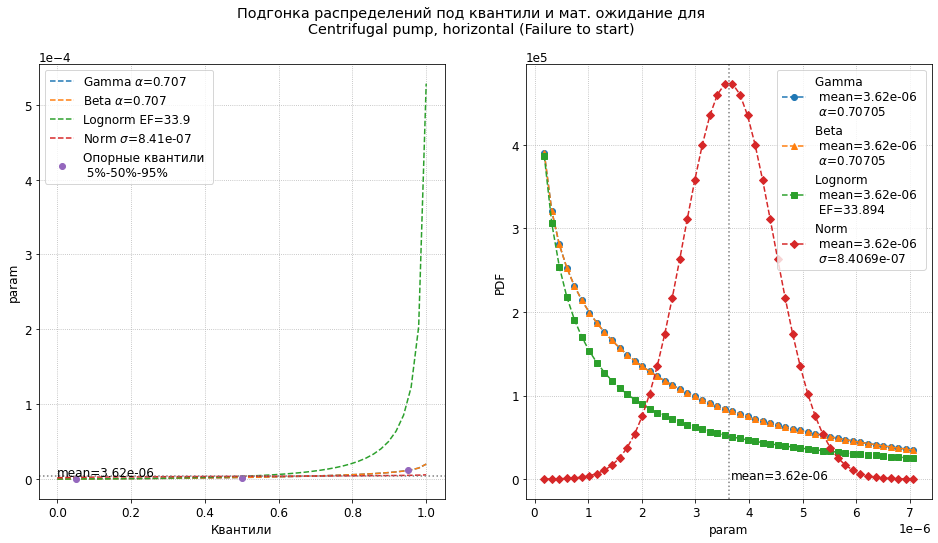

Fan (Spurious stop)
Gamma: param=0.43464, fun=5.1963e-11 
 Beta: param=0.43463, fun=5.1963e-11
 Lognorm: param=19.739, fun=1.4725e-11
 Norm: param=4.0409e-06, fun=2.3679e-09


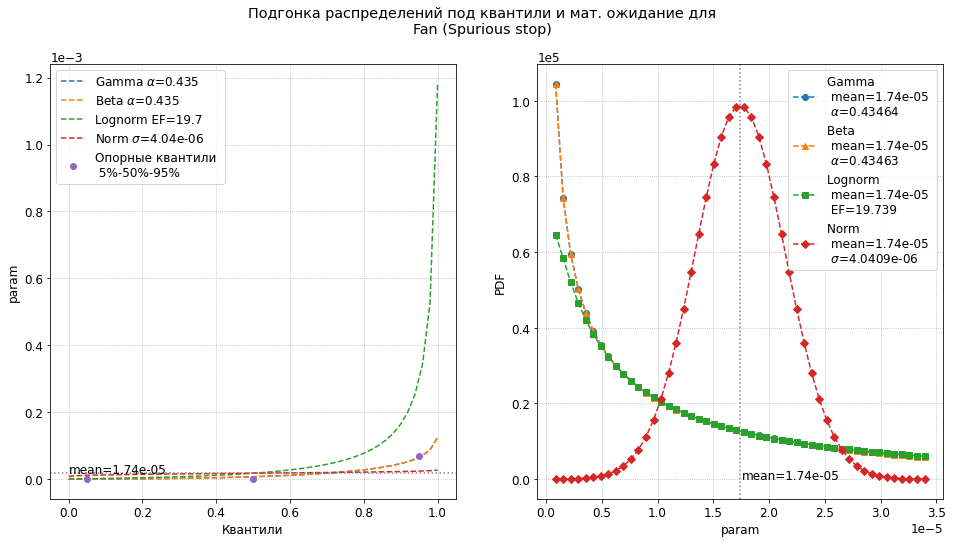

Fan (Failure to start)
Gamma: param=0.20705, fun=2.2614e-15 
 Beta: param=0.20705, fun=2.2615e-15
 Lognorm: param=15.39, fun=1.1139e-12
 Norm: param=1.974e-07, fun=1.0872e-11


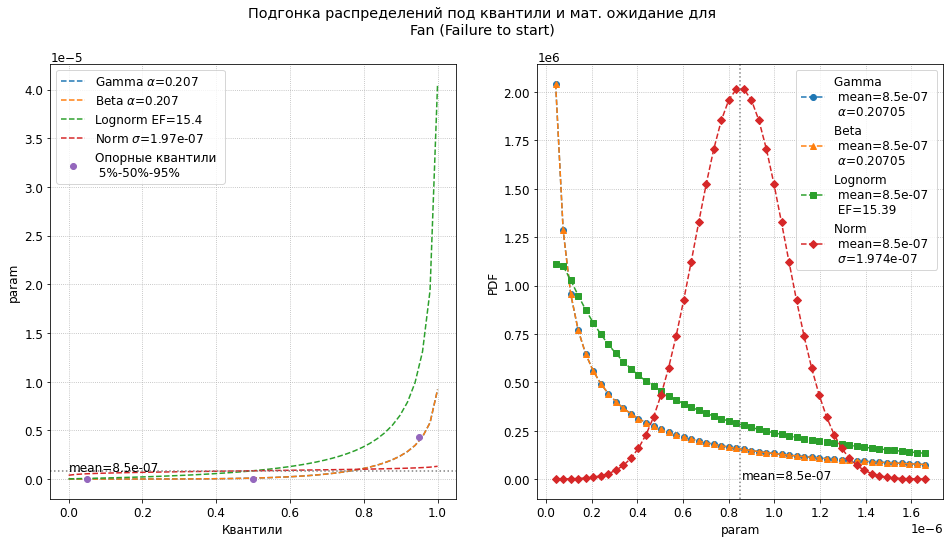

Isolation valves, motor operated, gate valve (Failure to change position)
Gamma: param=0.88694, fun=4.4875e-16 
 Beta: param=0.88693, fun=4.4871e-16
 Lognorm: param=42.063, fun=3.4884e-12
 Norm: param=7.4315e-07, fun=3.5845e-11


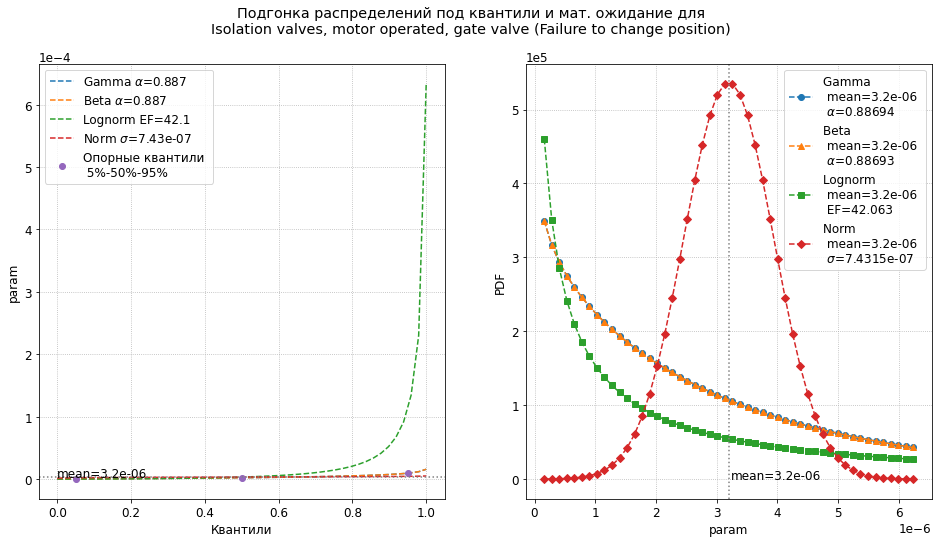

In [18]:

# Задаём квантили
q = np.array([0.05, 0.5, 0.95])

for row in df.itertuples():
    print(row.name)
    # Задаём значения квантилей
    d = np.array([row.p05 , row.p50, row.p95])
    # Задаём мат. ожидание (mean)
    m = row.mean
    # Название для рисования графиков
    name = row.name

    # Вызываем функцию подгонки для каждого типа распределения,
    # с учётом ограничений на допустимые значения параметров в RiskSpec
    (a_gamma, a_gamma_fun)  = distr_fit('gamma', q, d, m, bounds=[0.1,20])
    (a_beta, a_beta_fun) = distr_fit('beta', q, d, m, bounds=[0.1,20])
    (a_lognorm, a_lognorm_fun) = distr_fit('lognorm', q, d, m, bounds=[1,10000])
    (a_norm, a_norm_fun) = distr_fit('norm', q, d, m, bounds =[0, 0.608*m])
    
    # Выводим полученные параметры с "ошибкой"
    print(f'Gamma: param={a_gamma:0.5}, fun={a_gamma_fun:0.5} \n',
          f'Beta: param={a_beta:0.5}, fun={a_beta_fun:0.5}\n',
          f'Lognorm: param={a_lognorm:0.5}, fun={a_lognorm_fun:0.5}\n', 
          f'Norm: param={a_norm:0.5}, fun={a_norm_fun:0.5}')
    
    # Рисуем график вероятностного распределения
    # https://en.wikipedia.org/wiki/Quantile_function
    x = np.linspace(0,1)
    qq = np.linspace(0.01,0.99)
    
    fig, axs = plt.subplots(nrows=1, ncols=2)
    fig.suptitle(f'Подгонка распределений под квантили и мат. ожидание для\n{name}')
    
    axs[0].plot(x, gamma.ppf(qq, a=a_gamma, scale=m/a_gamma), '--')
    axs[0].plot(x, beta.ppf(qq, a=a_beta, b=a_beta/m-a_beta), '--')
    axs[0].plot(x, lognorm.ppf(qq, s=np.log(a_lognorm)/1.64485, scale= m), '--')
    axs[0].plot(x, norm.ppf(qq, loc=m, scale=a_norm), '--')
    axs[0].plot(q, d,'o')
    axs[0].set_ylabel('param')
    axs[0].set_xlabel('Квантили')
    axs[0].legend([f'Gamma $\\alpha$={a_gamma:0.3}',
                f'Beta $\\alpha$={a_beta:0.3}',
                f'Lognorm EF={a_lognorm:0.3}', 
                f'Norm $\\sigma$={a_norm:0.3}',
                f'Опорные квантили \n 5%-50%-95%'])

    axs[0].grid(linestyle=':')
    axs[0].text(0, m*1.01, f'mean={m}')
    axs[0].axhline(m, ls=':', color='grey')
    axs[0].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    
    # Рисуем график плотности
    tr = 0.95*m
    x = np.linspace(m-tr,m+tr)
    axs[1].plot(x, gamma.pdf(x, a=a_gamma, scale=m/a_gamma), 'o--')
    axs[1].plot(x, beta.pdf(x, a=a_beta, b=a_beta/m-a_beta), '^--')
    axs[1].plot(x, lognorm.pdf(x, s=np.log(a_lognorm)/1.64485, scale= m), 's--')
    axs[1].plot(x, norm.pdf(x, loc=m, scale=a_norm), 'D--')
    axs[1].set_ylabel('PDF')
    axs[1].set_xlabel('param')
    axs[1].legend([f'Gamma \n mean={m:0.3} \n $ \\alpha$={a_gamma:0.5}',
                f'Beta \n mean={m:0.3} \n $ \\alpha$={a_beta:0.5}',
                f'Lognorm \n mean={m:0.3} \n EF={a_lognorm:0.5}', 
                f'Norm \n mean={m:0.3} \n $ \\sigma$={a_norm:0.5}'])

    axs[1].grid(linestyle=':')
    axs[1].text(m*1.01, 0, f'mean={m}')
    axs[1].axvline(m, ls= ':', color='grey')
    axs[1].ticklabel_format(axis="both", style="sci", scilimits=(0,0))
    # Сохранение графика в файл. 
    plt.savefig(f'distribution_fitting_{name}.svg', format="svg" , transparent=True)
    plt.show()